In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg  
from math import sqrt,floor
from sklearn.metrics import mean_squared_error as mse

In [2]:
population = pd.read_csv('../data/curated/suburb_population2001-2021.csv')
income = pd.read_csv('../data/curated/suburb_income.csv')
rental = pd.read_csv('../data/curated/select_rent.csv',index_col=0) 

In [3]:
# Find suburbs that appears in all three dataframes
target_suburb = list(set(population.Suburb) & set(income.Suburb) & set(rental.Suburb))

In [4]:
select_population = population[population['Suburb'].isin(target_suburb)].drop_duplicates(['Suburb'])
cols = range(18) 
# the column containing data of year 2018
# Select data from beginning to 2018
time_population = select_population.set_index('Suburb').iloc[:,cols]

In [5]:
select_income = income[income['Suburb'].isin(target_suburb)].drop_duplicates(['Suburb'])
time_income = select_income.set_index('Suburb').drop('SA2_code', axis=1)

In [6]:
select_rental = rental[rental['Suburb'].isin(target_suburb)].drop_duplicates(['Suburb'])
# Select median rantal price from 2004 to 2018
# There are incorrect values before 2004
cols = [0] + list(range(32,152,2)) 
time_rental = select_rental.iloc[:, cols].set_index('Suburb')

In [7]:
# Replace missing value by column mean
time_rental = time_rental.replace('-', np.nan).astype(float)
time_rental = time_rental.apply(lambda x: x.fillna(x.mean()),axis=0)

### Predict Growth Rate for Rental Price

predicted=532.195682, expected=530.000000
predicted=536.457838, expected=530.000000
predicted=540.280078, expected=520.000000
predicted=544.203326, expected=523.000000
predicted=547.805399, expected=530.000000
predicted=548.844430, expected=540.000000
predicted=550.834643, expected=550.000000
predicted=553.173314, expected=560.000000
predicted=556.138827, expected=562.000000
predicted=559.273610, expected=560.000000
predicted=561.903235, expected=570.000000
predicted=564.501318, expected=575.000000
Test RMSE: 11.404


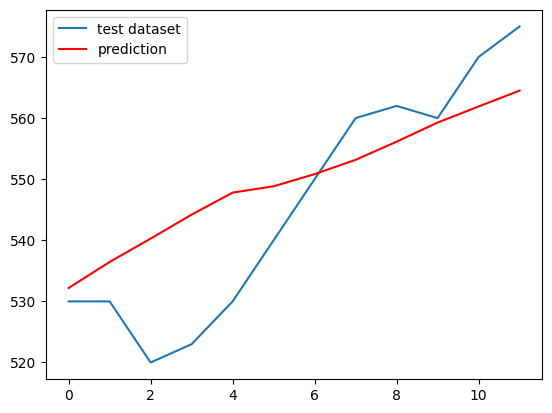

In [8]:
# This section is guide for tuning hyperparameter 'lags' in AutoReg
# We fount 10 is a resonable lag for rental price
# The same process for other two dataframes will be omitted
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
# split into train and test sets
X = time_rental.values[3]
train_size = floor(len(X)*0.8)
train, test = X[:train_size], X[train_size:]
# train autoregression
model = AutoReg(train, lags=10)
model_fit = model.fit()
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mse(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test, label='test dataset')
plt.plot(predictions, color='red', label='prediction')
plt.legend(loc="upper left")
plt.show()

In [10]:
all_predictions = list()
for X in time_rental.values:
    model = AutoReg(X, lags=10) # this value is tuned using train test split and observing MSE
    model_fit = model.fit()
    # predict rental price in seasons, until 2025
    all_predictions.append(model_fit.predict(start=len(X), end=len(X)+27, dynamic=False))

In [11]:
pred = pd.DataFrame(all_predictions)

In [12]:
# Set column name to format {year}.{month}
predict_rent = pd.concat([time_rental, pred.set_index(time_rental.index)], axis=1)
month = ['3', '6', '9', '12']
cols = []
year = list(range(2004,2026))
year = [str(x) for x in year]
for i in year:
    for j in month:
        cols.append(f'{i}.{j}')
predict_rent.columns = cols

In [13]:
predict_rent

,2004.3,2004.6,2004.9,2004.12,2005.3,2005.6,2005.9,2005.12,2006.3,2006.6,...,2023.9,2023.12,2024.3,2024.6,2024.9,2024.12,2025.3,2025.6,2025.9,2025.12
Suburb,,,,,,,,,,,,,,,,,,,,,
ALBERT PARK,300.0,300.0,300.0,300.0,300.0,300.0,310.0,300.0,313.0,320.0,...,613.232922,614.303797,616.351759,618.862812,622.043080,624.724560,626.186824,627.582593,629.286024,631.360609
MIDDLE PARK,300.0,300.0,300.0,300.0,300.0,300.0,310.0,300.0,313.0,320.0,...,613.232922,614.303797,616.351759,618.862812,622.043080,624.724560,626.186824,627.582593,629.286024,631.360609
ARMADALE,240.0,235.0,240.0,240.0,240.0,243.0,245.0,245.0,250.0,260.0,...,465.580249,456.743240,451.860420,448.021731,449.979000,454.039228,461.300716,470.691581,479.147033,488.238190
CARLTON NORTH,295.0,300.0,300.0,300.0,300.0,300.0,300.0,305.0,320.0,320.0,...,614.308649,616.179348,618.143028,619.779484,621.406020,623.085250,624.659684,626.261048,627.849645,629.426542
CARLTON,285.0,285.0,280.0,280.0,281.0,280.0,280.0,280.0,275.0,275.0,...,498.946889,502.063004,506.595802,509.877797,514.503652,518.051623,522.620837,526.116834,530.601341,534.253465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SWAN HILL,150.0,150.0,150.0,150.0,155.0,160.0,160.0,160.0,165.0,165.0,...,270.039865,271.090924,271.971021,272.803835,273.699639,274.540473,275.368956,276.266057,277.044945,277.873672
TORQUAY,220.0,220.0,220.0,225.0,225.0,240.0,250.0,250.0,258.0,260.0,...,567.177772,570.709703,574.157515,577.589729,581.027707,584.395419,587.792142,591.124857,594.461031,597.766810
TRARALGON,158.0,160.0,160.0,160.0,165.0,170.0,165.0,170.0,170.0,170.0,...,289.241039,289.235732,289.586349,289.648945,290.217754,290.417254,290.629921,290.805233,291.001054,291.356587


In [14]:
# Calculate 3, 5, 7 year predictions 
growth_rate_rent_3_years = (predict_rent['2021.12'] - 
                                       predict_rent['2018.12']) / predict_rent['2018.12']
growth_rate_rent_5_years = (predict_rent['2023.12'] - 
                                       predict_rent['2018.12']) / predict_rent['2018.12']
growth_rate_rent_7_years = (predict_rent['2025.12'] - 
                                       predict_rent['2018.12']) / predict_rent['2018.12']

In [15]:
# Create growth dataframe
growth_rate_rent = pd.DataFrame([growth_rate_rent_3_years, 
                                 growth_rate_rent_5_years,
                                 growth_rate_rent_7_years]).transpose()
growth_rate_rent.columns = ['% Growth in 3 years','% Growth in 5 years', '% Growth in 7 years']

In [16]:
# Sort rental growth in descending order
growth_rate_rent_sorted = growth_rate_rent.sort_values('% Growth in 7 years', ascending=False)
growth_rate_rent_sorted['rental rank'] = range(1,len(growth_rate_rent_sorted)+1)

In [17]:
growth_rate_rent_sorted

,% Growth in 3 years,% Growth in 5 years,% Growth in 7 years,rental rank
Suburb,,,,
SEYMOUR,0.136429,0.238044,0.350724,1
WARRAGUL,0.142594,0.233166,0.324134,2
BENALLA,0.085659,0.166265,0.253300,3
CARLTON,0.101324,0.173044,0.248256,4
PARKVILLE,0.101324,0.173044,0.248256,5
...,...,...,...,...
COLLINGWOOD,-0.004452,-0.004973,-0.005791,179
SOUTH MELBOURNE,0.000420,-0.004747,-0.008242,180
SOUTHBANK,-0.009055,-0.015547,-0.018029,181


### Predict Growth Rate for Income

In [18]:
# train autoregression
all_predictions = list()
for X in time_income.values:
    model = AutoReg(X, lags=3)
    model_fit = model.fit()
    all_predictions.append(model_fit.predict(start=len(X), end=len(X)+6, dynamic=True))

In [19]:
pred = pd.DataFrame(all_predictions)

In [20]:
# Combine original dataframe with prediction, set column name to years
predict_income = pd.concat([time_income, pred.set_index(time_income.index)], axis=1)
COLS = list(range(2005, 2026))
predict_income.columns = [str(x) for x in COLS]

In [21]:
predict_income

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Suburb,,,,,,,,,,,,,,,,,,,,,
EAST MELBOURNE,80524.0,87975.0,79947.0,90831.0,95349.0,105396.0,107768.0,104960.0,116888.0,114762.0,...,124057.0,128069.0,132130.0,134182.183075,137079.391290,139449.221777,141760.950410,143921.983906,145945.714623,147849.342574
SOUTHBANK,61242.0,67480.0,65682.0,70876.0,71064.0,82798.0,88106.0,87449.0,87266.0,89607.0,...,91651.0,94718.0,94237.0,94824.629469,95261.332643,95591.798397,95862.997988,96082.486353,96259.872664,96403.349560
DOCKLANDS,56900.0,62884.0,64625.0,64491.0,64633.0,69732.0,73182.0,71884.0,72349.0,72972.0,...,68978.0,69260.0,71476.0,71947.734960,71226.981595,71218.065041,71767.454947,71936.076671,71768.810211,71747.747056
FOOTSCRAY,36482.0,37360.0,38467.0,41170.0,42943.0,42600.0,45491.0,46902.0,48180.0,49954.0,...,52664.0,55519.0,57701.0,58773.972116,60990.266300,63356.491805,65010.395604,67069.300700,69450.270443,71495.424384
SEDDON,36635.0,38005.0,39443.0,42187.0,43745.0,57518.0,59896.0,61714.0,63637.0,65726.0,...,71878.0,75083.0,78218.0,80143.853017,82098.734641,83973.415586,85698.427115,87305.576165,88805.206691,90202.486947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MORNINGTON,37877.0,41007.0,40777.0,44590.0,43980.0,47445.0,49575.0,50799.0,53760.0,55845.0,...,58594.0,60236.0,62275.0,63783.125984,65609.617470,67242.958145,68930.679805,70574.889718,72205.370808,73818.400511
DROMANA,33249.0,34807.0,35095.0,37260.0,39295.0,42105.0,46850.0,47982.0,49683.0,51660.0,...,55235.0,57195.0,59787.0,61641.351064,63392.385370,65136.809059,66834.287710,68479.691938,70077.207052,71628.668024
PORTSEA,39071.0,41569.0,37181.0,41806.0,42168.0,45563.0,47878.0,49674.0,51972.0,52866.0,...,59717.0,60284.0,61551.0,63166.906653,64670.188990,66164.471756,67575.478105,68938.774445,70239.312353,71488.018475


In [22]:
# Calculate 3, 5, 7 year predictions 
growth_rate_inc_3_years = (predict_income['2021'] - 
                                       predict_income['2018']) / predict_income['2018']
growth_rate_inc_5_years = (predict_income['2023'] - 
                                       predict_income['2018']) / predict_income['2018']
growth_rate_inc_7_years = (predict_income['2025'] - 
                                       predict_income['2018']) / predict_income['2018']

In [23]:
# Create growth dataframe
growth_rate_inc = pd.DataFrame([growth_rate_inc_3_years, 
                                growth_rate_inc_5_years, 
                                growth_rate_inc_7_years]).transpose()
growth_rate_inc.columns = ['% Growth in 3 years','% Growth in 5 years', '% Growth in 7 years']

In [24]:
# Sort income growth in descending order
growth_rate_inc_sorted = growth_rate_inc.sort_values('% Growth in 7 years', ascending=False)
growth_rate_inc_sorted['income rank'] = range(1,len(growth_rate_inc_sorted)+1)

In [25]:
growth_rate_inc_sorted

,% Growth in 3 years,% Growth in 5 years,% Growth in 7 years,income rank
Suburb,,,,
PORT MELBOURNE,0.532287,0.453935,0.453036,1
PRAHRAN,0.127777,0.225646,0.334359,2
WINDSOR,0.127777,0.225646,0.334359,3
FITZROY NORTH,0.132037,0.228007,0.330976,4
TOORAK,0.114668,0.203762,0.310954,5
...,...,...,...,...
BALWYN,0.009073,0.007415,0.005913,179
DOCKLANDS,-0.003609,0.006437,0.003802,180
CLAYTON,-0.008966,-0.008047,-0.006263,181


### Predict Growth Rate for Population

In [26]:
# train autoregression
all_predictions = list()
for X in time_population.values:
    model = AutoReg(X, lags=2)
    model_fit = model.fit()
    all_predictions.append(model_fit.predict(start=len(X), end=len(X)+6, dynamic=True))
pred = pd.DataFrame(all_predictions)


In [27]:
# Combine dataframes and set column to years
predict_population = pd.concat([time_population, pred.set_index(time_population.index)], axis=1)
COLS = list(range(2001, 2026))
predict_population.columns = [str(x) for x in COLS]

In [28]:
predict_population

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
Suburb,,,,,,,,,,,,,,,,,,,,,
EAST MELBOURNE,3731,3859,4243,4460,4495,4555,4806,5055,5202,5272,...,5475,5495,5409,5405.895683,5413.669601,5421.457454,5427.901432,5433.064338,5437.175355,5440.444824
SOUTHBANK,5883,6050,6222,6467,6575,6704,6872,6985,7134,7174,...,8617,8760,8937,9124.562876,9316.500586,9510.815229,9706.866522,9904.454090,10103.520136,10304.053108
DOCKLANDS,154,926,1913,3089,3779,4152,4592,5040,5402,5780,...,11832,13923,15439,17102.191209,18921.490194,20908.317968,23076.152774,25440.308108,28017.851416,30827.612715
FOOTSCRAY,11564,11562,11615,11619,11731,11828,12085,12462,12815,13214,...,17343,17665,17891,18138.019776,18397.346754,18662.766051,18929.870531,19195.560566,19457.681363,19714.760067
SEDDON,4144,4143,4163,4181,4206,4256,4285,4341,4394,4419,...,4980,5011,5028,5034.074713,5030.628232,5019.164715,5001.225467,4978.334031,4951.949897,4923.431035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MORNINGTON,19118,19952,20347,20762,21151,21497,21966,22460,22854,23164,...,25030,25492,25897,26271.744938,26641.253087,27010.047932,27378.947500,27748.099872,28117.532001,28487.248942
DROMANA,3382,3422,3429,3433,3435,3454,3532,3621,3692,3699,...,4581,4803,4983,5194.185960,5435.963710,5709.274935,6016.151322,6359.458188,6742.756164,7170.237392
PORTSEA,1318,1347,1365,1369,1372,1378,1381,1385,1387,1388,...,1499,1530,1561,1598.279911,1642.367961,1694.219347,1755.087626,1826.495887,1910.251412,2008.482100


In [29]:
# Calculate growth rate
growth_rate_pop_3_years = (predict_population['2021'] - 
                                       predict_population['2018']) / predict_population['2018']
growth_rate_pop_5_years = (predict_population['2023'] - 
                                       predict_population['2018']) / predict_population['2018']
growth_rate_pop_7_years = (predict_population['2025'] - 
                                       predict_population['2018']) / predict_population['2018']

In [30]:
growth_rate_pop = pd.DataFrame([growth_rate_pop_3_years, 
                                growth_rate_pop_5_years,
                                growth_rate_pop_7_years]).transpose()
growth_rate_pop.columns = ['% Growth in 3 years','% Growth in 5 years', '% Growth in 7 years']

In [31]:
# Sort population growth in descending order
growth_rate_pop_sorted = growth_rate_pop.sort_values('% Growth in 7 years', ascending=False)
growth_rate_pop_sorted['population rank'] = range(1,len(growth_rate_pop_sorted)+1)

In [32]:
growth_rate_pop_sorted

,% Growth in 3 years,% Growth in 5 years,% Growth in 7 years,population rank
Suburb,,,,
PORT MELBOURNE,45.638458,599.293951,7730.242875,1
WERRIBEE,0.550078,1.491042,3.548471,2
GROVEDALE,0.359733,0.756235,1.356717,3
DOCKLANDS,0.354253,0.647795,0.996736,4
ALFREDTON,0.261136,0.492408,0.781762,5
...,...,...,...,...
DANDENONG,-0.011237,-0.039301,-0.077942,179
BROADMEADOWS,0.013002,-0.021043,-0.088877,180
CAMBERWELL,-0.026312,-0.060958,-0.100315,181


### Different Growth Rates in each Suburbs
We can save the growth rate of each attribute for further analysis \
Since 7 year may cause inaccuracy because of extrapolation, we will use 5 year prediction after \
However, we still rank suburbs according to 7 year growth

In [33]:
growth_5_years = pd.DataFrame([growth_rate_rent['% Growth in 5 years'], 
                              growth_rate_inc['% Growth in 5 years'],
                              growth_rate_pop['% Growth in 5 years']]).transpose()
growth_5_years.columns= ['% rental price Growth in 5 years',
                       '% income Growth in 5 years',
                      '% population Growth in 5 years']

In [34]:
growth_5_years['average'] = growth_5_years.mean(axis=1)
growth_5_years_sorted = growth_5_years.sort_values('average', ascending=False)

In [35]:
growth_5_years_sorted

,% rental price Growth in 5 years,% income Growth in 5 years,% population Growth in 5 years,average
Suburb,,,,
PORT MELBOURNE,0.042947,0.453935,599.293951,199.930277
WERRIBEE,0.048609,0.186259,1.491042,0.575304
GROVEDALE,0.068275,0.134769,0.756235,0.319760
ALFREDTON,0.070253,0.093947,0.492408,0.218869
DOCKLANDS,-0.043949,0.006437,0.647795,0.203428
...,...,...,...,...
BROADMEADOWS,0.011098,0.055021,-0.021043,0.015025
HAWTHORN,0.016112,0.010984,0.012829,0.013309
LALOR,0.030918,0.113720,-0.123305,0.007111


In [36]:
growth_5_years_sorted.to_csv('../data/curated/suburb_growth_5_years.csv')

### Ranking of Suburbs

In [37]:
ranking = pd.DataFrame([growth_rate_rent_sorted['rental rank'],
                        growth_rate_inc_sorted['income rank'], 
                        growth_rate_pop_sorted['population rank']]).transpose()

In [38]:
# Calculate average ranking of three ranks
# We give them equal weight because we think they are equally important when examing suburb growth
ranking['average rank'] = ranking.mean(axis=1)

In [39]:
# Use the average rank as final ranking of suburb growth
ranking = ranking.sort_values('average rank')

In [40]:
ranking

,rental rank,income rank,population rank,average rank
Suburb,,,,
DROMANA,11,29,10,16.666667
PORTSEA,12,54,16,27.333333
ASPENDALE,24,16,50,30.000000
GROVEDALE,54,34,3,30.333333
WERRIBEE,83,10,2,31.666667
...,...,...,...,...
HAWTHORN,157,176,129,154.000000
ESSENDON,155,136,177,156.000000
CAMBERWELL,130,169,181,160.000000


In [41]:
ranking.to_csv('../data/curated/suburb_ranking.csv')

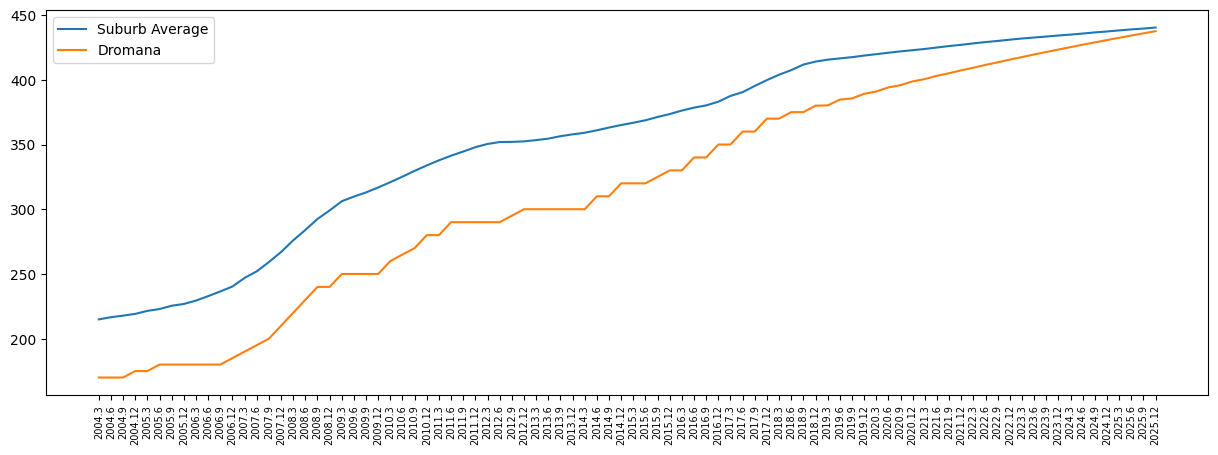

In [42]:
# We can Visualise suburb with highest ranking to observe some pattern
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(predict_rent.mean(), label="Suburb Average")
plt.plot(predict_rent.loc['DROMANA'], label="Dromana")
plt.tick_params(axis='x', labelsize=7, rotation=90)
plt.legend(loc="upper left")
plt.savefig('../plots/Dromana_rental_growth')
plt.show()

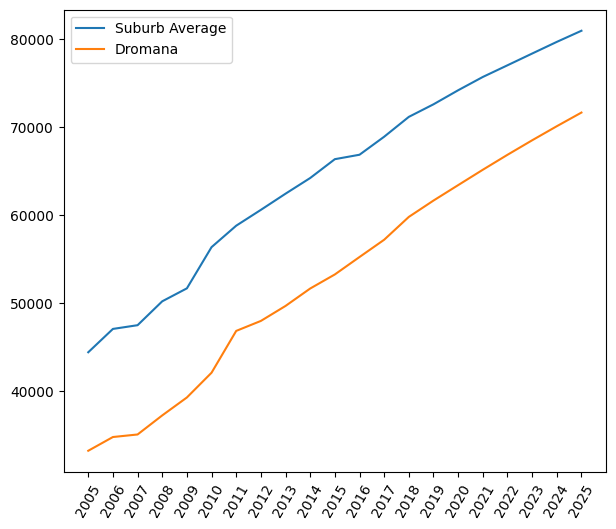

In [49]:
plt.rcParams['figure.figsize'] = [7,6]
plt.plot(predict_income.mean(), label="Suburb Average")
plt.plot(predict_income.loc['DROMANA'], label="Dromana")
plt.legend(loc="upper left")
plt.tick_params(axis='x',rotation=60)
plt.savefig('../plots/Dromana_income_growth')
plt.show()

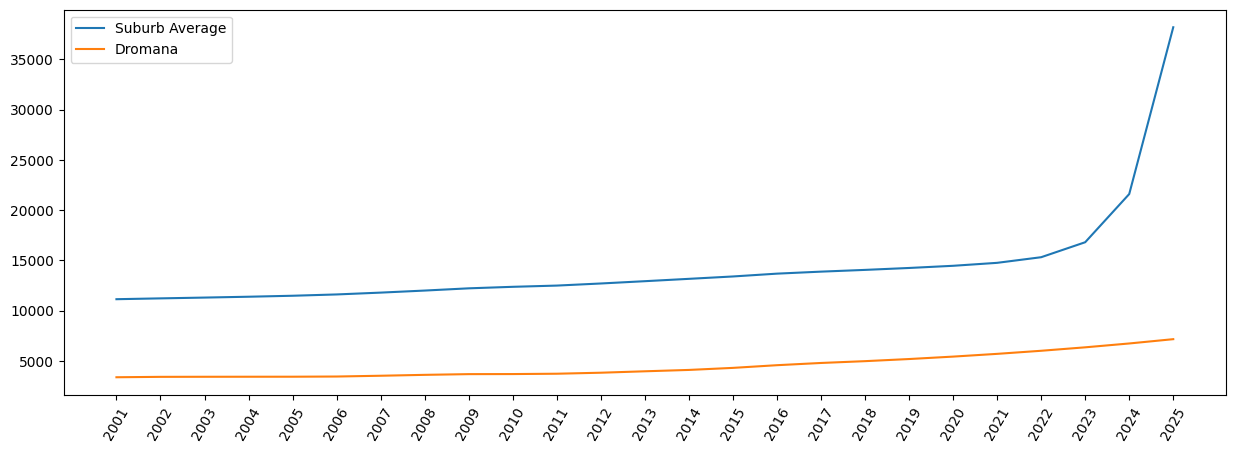

In [43]:
plt.plot(predict_population.mean(), label="Suburb Average")
plt.plot(predict_population.loc['DROMANA'], label="Dromana")
plt.legend(loc="upper left")
plt.tick_params(axis='x', rotation=60)
plt.savefig('../plots/Dromana_pop_growth')
plt.show()

# We found this plot is unreasonable
# due to the extrapolation of data, some predictions are exponentially growing